In [1]:
# Import necessary libraries
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# %matplotlib notebook

## Bias vs variance trade-off 
· Number of data points vs. Error.  
· Model complexity vs. Error.  
Performing an experiment with polynomials which shows this behaviour.

In [2]:
# Define a polynomial that we want to test (ie theoretical model)
poly = lambda x: 7.2 - 3.1 * x + 20 * x**3 - 1.3 * x**4 + 0.2 * x**5

# Noise on data
sigma = 500

# Seed random generator for repeatable results
np.random.seed(11041991)

# training and testing data
def create_data(npoints):
    x = np.linspace(-7, 8, npoints)
    # use sklearn for easy splitting of data, default is 25% test data
    xtrain, xtest = train_test_split(x) # shuffling is necessary here, and it's default
    # add Gaussian noise
    ytrain = poly(xtrain) + np.random.normal(0, sigma, xtrain.size)
    ytest = poly(xtest) + np.random.normal(0, sigma, xtest.size)
    return [xtrain, ytrain, xtest, ytest]

# Fit model of given complexity (here: polynomial degree) and return predictions for training and test set
def fit_model(data, deg):
    model = linear_model.LinearRegression()
    feat_gen = PolynomialFeatures(degree = deg) 
    ## This computes poly features, which are combinations of powers of the columns (og features, here only one)
    ## only one feature means need np.newaxis to still make it look like a column
    features_train = feat_gen.fit_transform(data[0][:, np.newaxis]) #training x set is in data[0]
    features_test = feat_gen.fit_transform(data[2][:, np.newaxis]) #test x set is in data[2]
    model.fit(features_train, data[1]) # use the linear regression optimal
    return [data[0], model.predict(features_train), data[2], model.predict(features_test)]

## Complexity

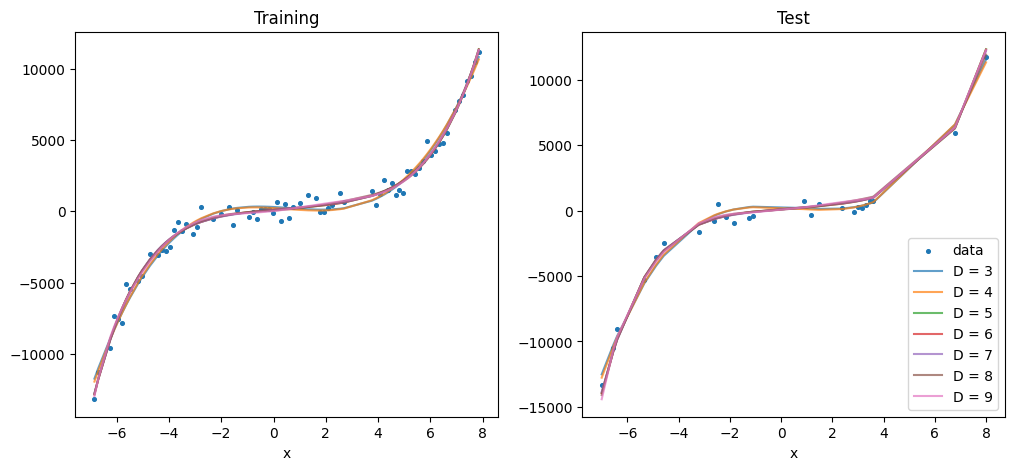

In [23]:
# Set range of polynomial degrees
Dmin = 3
Dmax = 10
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Correcting plt.subplot to plt.subplots and adding figure size

data = create_data(100)
### re order for plotting
sorted_indices = np.argsort(data[0])
sorted_indices2 = np.argsort(data[2])
x_sorted_train = data[0][sorted_indices]
x_sorted_test = data[2][sorted_indices2]
axs[0].scatter(data[0], data[1], label='data', s = 7)
axs[1].scatter(data[2], data[3], label='data', s= 7)

for D in range(Dmin, Dmax):
    prediction = fit_model(data, D)
    axs[0].plot(x_sorted_train, prediction[1][sorted_indices], label='D = ' + str(D), alpha = 0.7)
    axs[1].plot(x_sorted_test, prediction[3][sorted_indices2], label='D = ' + str(D), alpha = 0.7)

# Set labels and legends
axs[0].set_xlabel('x')
axs[0].set_title('Training')
# axs[0].legend(loc='lower right')
axs[1].set_xlabel('x')
axs[1].set_title('Test')
axs[1].legend(loc='lower right')

plt.show()

In [25]:
# Plot polynomial degree vs. mean squared error on test data
PolydegvsMSE = np.zeros([Dmax-Dmin+1, 3])

# repeat the experiment a few times to get a smoother graph
reps = 500
for i in range(1, reps+1):
    tmp = np.array([[0., 0., 0.]])
    for D in range(Dmin, Dmax, 1):
        data = create_data(100)
        prediction = fit_model(data, D)
        # use sklearn to compute mean squared error
        error_test = metrics.mean_squared_error(data[3], prediction[3])
        error_train = metrics.mean_squared_error(data[1], prediction[1])
        tmp = np.append(tmp, np.array([[D, error_test, error_train]]), axis=0)
    ### tmp = n_dims_tested x (D, error_test, error_train)
    ### PolydegvsMSE same but basically mean over multiple experiments
    PolydegvsMSE += tmp

PolydegvsMSE = PolydegvsMSE[1:] / reps

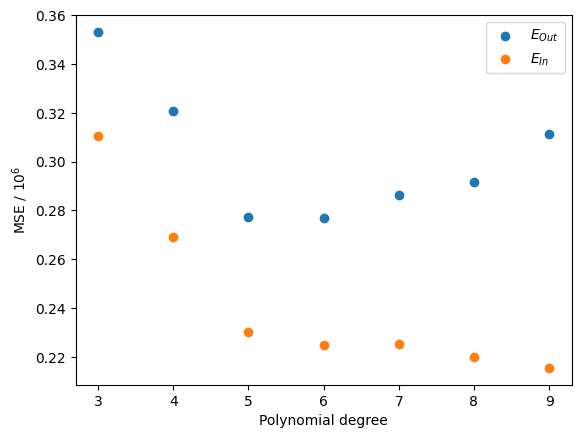

In [26]:
plt.scatter(PolydegvsMSE.T[0], PolydegvsMSE.T[1] / 10**6, label = '$E_{Out}$')
plt.scatter(PolydegvsMSE.T[0], PolydegvsMSE.T[2] / 10**6, label = '$E_{In}$')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE / $10^6$')
_ = plt.legend(loc='upper right')

### Comments
Overfitting starts from $deg = 5$, hence better on training, worse on test set.
By overfitting the training set, we have less bias but we train to close to training's variability and so have more variance error subsequently on test set.

## Number of data points

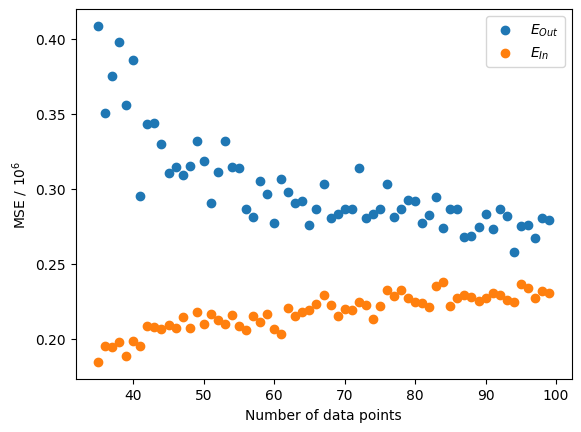

In [4]:
# Plot number of data points vs. mean squared error on test data

Nmin = 35
Nmax = 100

NDatavsMSE = np.zeros([Nmax-Nmin+1, 3])

# repeat the experiment a few times to get a smoother graph
reps = 100
for i in range(1, reps+1):
    tmp = np.array([[0., 0., 0.]])
    for N in range(Nmin, Nmax, 1):
        data = create_data(N)
        prediction = fit_model(data, 5)
        error_test = metrics.mean_squared_error(data[3], prediction[3])
        error_train = metrics.mean_squared_error(data[1], prediction[1])
        tmp = np.append(tmp, np.array([[N, error_test, error_train]]), axis=0)
    NDatavsMSE += tmp

NDatavsMSE = NDatavsMSE[1:] / reps

# plot out-of-sample error
plt.scatter(NDatavsMSE.T[0], NDatavsMSE.T[1] / 10**6, label = '$E_{Out}$')
# plot in-sample error
plt.scatter(NDatavsMSE.T[0], NDatavsMSE.T[2] / 10**6, label = '$E_{In}$')
plt.xlabel('Number of data points')
plt.ylabel('MSE / $10^6$')
_ = plt.legend(loc='upper right')

### Comments
With more data (and so complexity), it is more difficult to capture it all with a fixed model (here $deg = 5$): bias increase in the training, but we have a better capture of variability and so performs better (smaller variance) in the test set.